# Previsione di infarto

Per questa esercitazione dovrai utilizzare un dataset contenente diverse informazioni ed esami a pazienti per prevedere chi di loro è a rischio infarto. Quale metrica andrebbe ottimizzata in questo caso? Realizza un primo modello baseline e poi uno utilizzando le SVM.

Puoi scaricare il dataset [da qui](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset), di seguito le variabili che contiene:

 - **age**: Età del paziente

 - **sex**: Sesso del paziente

 - **cp**: Tipo di dolore toracico, 0 = Angina tipica, 1 = Angina atipica, 2 = Dolore non anginoso, 3 = Asintomatico

 - **trtbps**: Pressione arteriosa a riposo (in mm Hg)

 - **col**: Colesterolo in mg/dl rilevato tramite il sensore BMI

 - **fbs**: (glicemia a digiuno > 120 mg/dl), 1 = vero, 0 = falso

 - **restecg**: Risultati elettrocardiografici a riposo, 0 = normale, 1 = anormalità dell'onda ST-T, 2 = ipertrofia ventricolare sinistra

 - **thalachh**: Frequenza cardiaca massima raggiunta

 - **oldpeak**: Picco precedente

 - **slp**: Pendenza

 - **caa**: Numero di vasi principali

 - **thall**: Risultato dello Stress Test al Tallio ~ (0,3)

 - **exng**: Angina indotta dall'esercizio ~ 1 = Sì, 0 = No

 - **output**: Variabile target

Import dei moduli principali (man mano se ne aggiungono altri)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Carico il dataset

In [2]:
data = pd.read_csv("../datasets/heart.csv")
print(data.shape)
data.head()

(303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Bisognerebbe fare l'esplorazione dei dati, sia univariata che multivariata, anche per fare feature selection, ma essendo un esercizio e basta la skippo e uso tutte le variabili.

L'unica cosa da vedere comunque è se ci sono valori mancanti e se bisogna fare qualche encoding,

In [3]:
#valori mancanti
data.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

Ottimo, non ci sono valori mancanti.

Vedo le info generiche sulle variabili (il tipo)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


L'unica analisi esplorativa che qui faccio è sulla feature target, per vedere se il problema è bilanciato o meno.

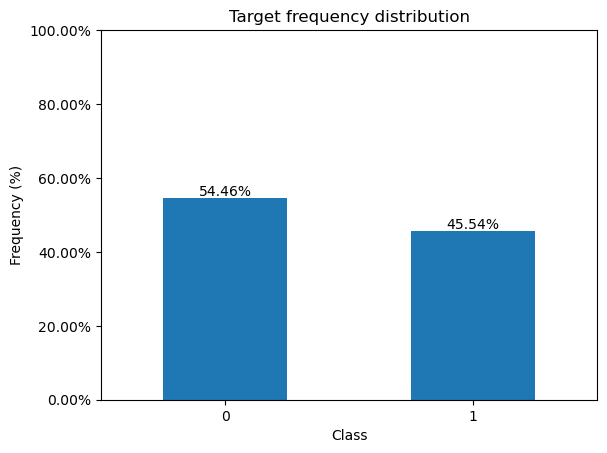

In [5]:
from matplotlib.ticker import PercentFormatter

relative_frequency = data["output"].value_counts(normalize = True)*100
ax=relative_frequency.plot(kind="bar",
                           title="Target frequency distribution",
                    xticks=[0,1], xlabel="Class", ylabel='Frequency (%)',
                          rot=0)
pf = PercentFormatter(xmax=100,decimals=2)
ax.yaxis.set_major_formatter(pf)
ax.bar_label(ax.containers[0], fmt='%.2f%%')
plt.ylim((0,100))
plt.show()

Le classi sono abbastanza bilanciate.

Vedendo anche su kaggle risulta che tutte le features sono già codificate in valori numerici.

### Nota sulle variabili restecg e cp
Queste due variabili sono qualitative, ma qui le interpreto come variabili ordinali piuttosto che nominali (categoriche).
La scala ordinale sarebbe gravità bassa (0) -> gravità alta (3), quindi l'encoding fatto è da considerare un OrdinalEncoding e non un NominalEncoding. Di conseguenza queste variabili saranno trattate come numeriche discrete, quindi applicando uno StandardScaler (invece del OneHotEncoding usato per le variabili nominali).

EDIT: La variabile cp in effetti non è odrinata, perchè i suoi livelli non hanno un significato di gravità, quindi per questa devo applicare il OneHotEncoding.
### Nota sulla variabile sex
La variabile sex è una variabile binaria (viva l'LGBT), ma è nominale, quindi per questa variabile devo applicare il OneHotEncoding.

EDIT: No per questa variabile va applicato solo il nominal encoding, perchè ha solo due categorie possibili. Se applico OneHotEncoding ottengo due colonne opposte (quindi linearmente dipendenti) e questo fa casino con i classificatori.

 ## Train test split e preprocessing
 Avendo poco più di 300 osservazioni, è meglio mantenersi bassi con la proporzione di elementi nel test set (20%). 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

RANDOM_SEED = 176

X = data.drop("output",axis=1)
y = data["output"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=RANDOM_SEED) 

In [7]:
categorical_features=["cp"]
numeric_features=X.drop(["sex","exng","fbs"],axis=1).columns.tolist()
ct = ColumnTransformer(
[
    ("ohe",OneHotEncoder(sparse_output=False, handle_unknown='ignore'),categorical_features),
    ("ss",StandardScaler(),numeric_features)
],remainder='passthrough'
)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

## Modelli
Devo provare due modelli:
regressione logistica (baseline) - apprende dai dati più rappresentativi
SVM (prova vari kernel) - apprende dai dati più promiscui.

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=176)

Valutazione del modello sul test set

In [9]:
from sklearn.metrics import classification_report
#si dovrebbe ottimizzare la soglia di classificazione con la ROC. 
#Qui si omette in qunato esercizio (si usa la soglia di default di 0.5).
y_pred_test_lr = lr.predict(X_test) 
 

print(classification_report(y_test,y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89        26
           1       0.94      0.89      0.91        35

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



#### Commento sulle metriche
L'obiettivo è di prevedere il rischio di infarto -> voglio evitare di farmi sfuggire positivi reali, quindi la metrica da ottimizzare è la sensibilità (recall). Anche che ci dovessero essere falsi positivi, non è un problema, questi saranno poi valutati con metodi più specifici.

### Modello di regressione logistica (baseline)
Ottengo una sensibilità del 96%, il che non è male. La precisione è del 68% e sarebbe meglio aumentarla un po' (quindi dovrebbe aumentare la specificità). 
Nel complesso l'accuratezza dell'80% è buona, ma si può fare meglio

Per il secondo modello SVM, provo con un kernel rbf (gaussiano)

In [10]:
from sklearn.svm import SVC

svm1 = SVC(kernel='rbf',gamma=1.0)
svm1.fit(X_train,y_train)
y_pred_test_svm1 = svm1.predict(X_test)

print(classification_report(y_test,y_pred_test_svm1))


              precision    recall  f1-score   support

           0       0.88      0.27      0.41        26
           1       0.64      0.97      0.77        35

    accuracy                           0.67        61
   macro avg       0.76      0.62      0.59        61
weighted avg       0.74      0.67      0.62        61



### Parametri usati nell'svm
Ho lasciato il valore di C di default (1.0), anche se si può pensare di aumentarlo per avere meno misclassificazioni.
Il valore di gamma è 1 (che è elevato), per fare in modo che il decision boundary sia molto vicino ai support vectors (warning overfitting).


#### Commenti sulle prestazioni dei svm1
Con questi parametri si ottiene una situazione abbastanza sbilanciata, perchè ho una sensibilità (recall) molto buona del 100%, però ho un'accuratezza e una precisione troppo basse. La specificità (che è recall della classe 0, v. documentazione sklearn) è davvero troppo bassa. Questo significa che ho pochi veri negativi (e da qui l'accuratezza bassa). 

Per completezza, verifico le prestazioni sullo stesso train set per vedere se ho overfitting o meno

In [11]:
print("Train set - SVM1")
print(classification_report(y_train,svm1.predict(X_train)))

Train set - SVM1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00       130

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242



Ecco, infatti... Sul train set ho tutte le classificazioni corrette, quindi sì, sono in overfitting

### Modello SVM2
Uso un altro modello svm, sempre con kernel rbf, però qui uso un valore di gamma più basso. Mettendo gamma = 'auto', risulta gamma=1/N_features


In [12]:
svm2 = SVC(kernel='rbf', gamma='auto')
svm2.fit(X_train,y_train)
y_pred_test_svm2 = svm2.predict(X_test)

print(classification_report(y_test,y_pred_test_svm2))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        26
           1       0.92      0.94      0.93        35

    accuracy                           0.92        61
   macro avg       0.92      0.91      0.92        61
weighted avg       0.92      0.92      0.92        61



In [13]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred_test_svm2))

[[23  3]
 [ 2 33]]


Verifico overfitting

In [14]:
print("Train set - SVM2")
print(classification_report(y_train,svm2.predict(X_train)))

Train set - SVM2
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       112
           1       0.84      0.95      0.89       130

    accuracy                           0.88       242
   macro avg       0.88      0.87      0.87       242
weighted avg       0.88      0.88      0.87       242



Non ho overfitting  perchè sul test set le prestazioni non scendono a picco (come prima).


Sul test set ottengo sensibilità = 100%, quindi non ho falsi negativi, il che è l'obiettivo del modello. Di contro ho una specificità del 68% (e infatti ho 12 falsi positivi)

In [62]:
svm3 = SVC(kernel='sigmoid', gamma='auto', coef0=1.2)
svm3.fit(X_train,y_train)
y_pred_test_svm3 = svm3.predict(X_test)

print(classification_report(y_test,y_pred_test_svm3))
print(confusion_matrix(y_test,y_pred_test_svm3))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87        26
           1       0.91      0.89      0.90        35

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61

[[23  3]
 [ 4 31]]


In [39]:
1/16

0.0625

In [33]:
data["cp"].value_counts()

cp
0    143
2     87
1     50
3     23
Name: count, dtype: int64

In [34]:
data.shape

(303, 14)

No, ho peggiorato le cose... Meglio restare al modello svm2.